In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from torch.utils.data import Dataset, SubsetRandomSampler

import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from tqdm import tqdm
tqdm.pandas()

/home/ivan/anaconda3/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
RS = 7345
np.random.seed(42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

# Загрузка данных

In [5]:
DATA_DIR = pathlib.Path("./")

In [6]:
train = pd.read_csv(DATA_DIR.joinpath("train.csv"), index_col="pair_id")
test = pd.read_csv(DATA_DIR.joinpath("test.csv"), index_col="pair_id")

In [7]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [8]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [11]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [12]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
41914,Basf Corporation,"Basf (China) Co., Ltd. Shanghai",1
197034,«ГК Полипласт»,ООО «Полипласт Новомосковск»,1
32829,"Thai Bridgestone Co., Ltd.",Shenyang Bridgestone,1
158600,Bridgestone De Costa Rica Sociedad Anoni,Bridgestone De Mexico S.A. De C.V.,1
256576,Ravago Ltd. (Hk),Ravago Distribution Sa,1
289303,Reliance Retail Ltd.,Reliance Brands,1
122345,Contitech Chile S.A.,Contitech Antriebssysteme Gmb H,1
460037,Basf Construction Chemicals,"Basf Co., Ltd.",1
138727,SOPREMA Polska Sp. z o.o.,Soprema Iberia,1


In [13]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
190047,"Bin Arif Industries Pvt., Ltd.",Eriks Industries Services Lp,0
443977,Eiffage SA (ENXTPA:FGR),Japan Synthetic Rubber Co,0
269625,Industrial El Sol S.A.C.,Sellos Y Empaques Industriales Sociedad,0
157622,Almas Carpet (Private) Ltd.,S K Inc.,0
289680,"Anconn Co., Ltd.",Importaciones Exportaciones,0
330080,Sun Deep Exp.,1 8168912400 Tel Ex 1 816891 76,0
409241,Master International,"Qingdao Jiesen Leather Products Co., Ltd.",0
462993,Nagda Grasim Industries Ltd.,Quimico Plasticos Industriales,0
445087,Playpoint Philippines Inc.,Samsung Electronics Philippines Corp,0


# Очистка данных

In [14]:
import pycountry
import re

In [15]:
countries = [country.name.lower() for country in pycountry.countries]

In [16]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [17]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [18]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|██████████| 7/7 [00:28<00:00,  4.05s/it]


In [19]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries (india),0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [20]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [21]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [23]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

In [24]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [25]:
train.sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
47630,trp international,shipco transportbos,0
381358,danosa france,hydrotech membranes,0
325738,victoria sports leisure pl,joma sport sa,0
348016,ace international ag,sanco sp a,0
170849,pink city logistics usa llc,round the world logistics,0
461245,lomex india private,nilfisk india private,0
442070,velfix industries,nanhai light industrial products imp expof gu...,0
435970,leafar technology sac,road to rubber technology,0
43015,al bashir trading,brothers trading,0


In [26]:
test.sample(25)

,name_1,name_2
pair_id,,
88222,tireinc,jysk linen n furniture
26882,qingdao grt rubber,rohit rubberporation
175569,achem technologyp,hira technologies
164119,cronos logistica,yes logisticsp
75642,faj international,unique fabricating de mexico sa de cv
178782,nri,clear freight
187139,nnr global logistics mexico sa de,lf logistics usa llc chi
185046,coco paving,iko slovakia
97793,siam rubber,global rubber industries


In [27]:
train['full_name'] = train['name_1'] + ' # ' + train['name_2']
test['full_name'] = test['name_1'] + ' # ' + test['name_2']

## removing shit words

In [ ]:
shit_words = ['sa', 's a', 'de', 'cv', 'gmb h', 'g mbh', 'llc', 's pa', 'sp a', 'spa', 'ag', 'rl', 's']

In [ ]:
for shit_word in tqdm(shit_words):
    train.replace(re.compile('\s+{}'.format(shit_word)), "", inplace=True)
    test.replace(re.compile(f"\s+{shit_word}\s*"), "", inplace=True)

## adding new pairs

In [ ]:
def generator(train, how_many = 1, which_column = 'both'):
    #генерация случайных названий
    #train - pd.DataFrame
    #how_many - сколько раз прогнать через рандомную склейку
    #which_column - какую колонку брать за исходник для генерации. При значении "both" используются обе колонки
    
    import random
    
    to_add = pd.DataFrame([[0,0], [0,0]])
    
    if which_column == 'both':

        exp_df_1 = train.iloc[:,0].str.split(' ', expand = True)
        exp_df_2 = train.iloc[:,1].str.split(' ', expand = True)
        
        secondaries_ser_1 = pd.concat([exp_df_1[2].drop_duplicates(), exp_df_1[1].drop_duplicates()]).dropna().reset_index(drop=True)
        secondaries_ser_2 = pd.concat([exp_df_2[2].drop_duplicates(), exp_df_2[1].drop_duplicates()]).dropna().reset_index(drop=True)
        
        secondaries_ser = pd.concat([secondaries_ser_1, secondaries_ser_2]).drop_duplicates().reset_index(drop=True)
        
        to_add = pd.concat([exp_df_1[0].drop_duplicates().reset_index(drop = True), exp_df_2[0].drop_duplicates().reset_index(drop = True)]).dropna()
        
        for ix in np.arange(how_many):
            
            to_add_proc = pd.DataFrame([[str(x) + ' ' + random.choice(secondaries_ser.to_numpy()) for x in to_add], [str(x) + ' ' + random.choice(secondaries_ser.to_numpy()) for x in to_add]]).T
 
            if ix == 0:
                final = to_add_proc
            else:
                final = pd.concat([final, to_add_proc])

    return final.drop_duplicates().reset_index(drop = True)

In [ ]:
a = generator(train, how_many = 20, which_column = 'both')

In [ ]:
a

# Токенизатор

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

In [29]:
train['full_name'].iloc[0]

'iko industries # enormous industrial trade'

In [30]:
def tokenize(s):
    encoded_dict = tokenizer.encode_plus(s,
                                         add_special_tokens=True,
                                         max_length=512,
                                         pad_to_max_length=True,
                                         return_attention_mask=True,
                                         return_tensors='pt',
                                         truncation=True)
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

### Побуквенный токенизатор

In [31]:
# Идея простая - в качестве токена символа используем номер символа Юникода
# Для CLS токен 99998, для SEP 99999
def char_tokenize(sample, length=512):
    if len(sample) > length:
        sample = sample[:length]
    
    res = np.array([0] * length)
    att = np.array([0] * length)
    
    for i, char in enumerate(sample):
        res[i + 1] = ord(char)
        att[i + 1] = 1
    res[0] = 99998
    res[i + 2] = 99999
    att[0] = 1
    att[i + 2] = 1
    
    res = torch.tensor(res, dtype=torch.int64).reshape(1, -1)
    att = torch.tensor(att, dtype=torch.int64).reshape(1, -1)

    return res, att 

# Датасет

In [41]:
class SiburDataset(Dataset):
    """Делаем бутстрапированную (с повторениями) выборку, сбалансированную по классам.
    Для экономии памяти делаем токанизацию в процессе выборки сэмплов."""
    def __init__(self, ones, zeros, size=2048, p=0.5, tokenizer=char_tokenize):
        """
        size - размер выборки, т.е. фактически размер датасета для одной эпохи.
        ones - все положительные сэмплы датасета.
        zeros - все отрицательные сэмплы датасета.
        p - вероятность положительного сэмпла. 0.5 для сбалансированной выборки.
        """
        self.size = size
        self.ones = ones
        self.zeros = zeros
        self.ones_len = len(ones)
        self.zeros_len = len(zeros)
        self.p = p
        self.tokenizer = tokenizer
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if idx >= self.size:
            raise StopIteration
        
        # Решаем, какой сэмпл выдать
        if np.random.random() < self.p:
            sample = self.ones[np.random.randint(0, self.ones_len)]
            target = 1
        else:
            sample = self.zeros[np.random.randint(0, self.zeros_len)]
            target = 0
        
        X, att = self.tokenizer(sample)
        target = torch.tensor(target, dtype=torch.long)
        
        return X.reshape(-1), att.reshape(-1), target

In [42]:
class SiburPredictDataset(Dataset):
    """Датасет для финального предикта."""
    def __init__(self, data, tokenizer=char_tokenize):
        self.data = data
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        
        X, att = self.tokenizer(sample)
        
        return X.reshape(-1), att.reshape(-1)

In [43]:
#тренировочная, валидационная выборки
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=42)
tridx, cvidx = list(split.split(train, train["is_duplicate"]))[0]

In [44]:
trdat = train.iloc[tridx]
valdat = train.loc[cvidx]

In [45]:
batch_size=4
ones = trdat.loc[trdat['is_duplicate'] == 1, 'full_name'].values
zeros = trdat.loc[trdat['is_duplicate'] == 0, 'full_name'].values
train_dataset = SiburDataset(ones, zeros, p=0.1, size=2048)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

In [46]:
batch_size=4
ones = valdat.loc[valdat['is_duplicate'] == 1, 'full_name'].values
zeros = valdat.loc[valdat['is_duplicate'] == 0, 'full_name'].values
valid_dataset = SiburDataset(ones, zeros, p=0.1, size=2048)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [47]:
# Проверка датасета
for X, att, target in train_loader:
    pass

# Модель

In [48]:
class SiburBerta(torch.nn.Module):
    """Используем мультиязычную Берту в качестве основы, прикручиваем два
    линейных слоя на вторую голову."""
  
    def __init__(self, freeze=False):
        super(SiburBerta, self).__init__()
        
        self.backbone = BertModel.from_pretrained('bert-base-multilingual-uncased')
        
        # замораживаем Берту
        if freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        self.relu = torch.nn.ReLU()
        self.linear_1 = torch.nn.Linear(in_features=768, out_features=64)
        self.linear_2 = torch.nn.Linear(in_features=64, out_features=2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, X, att):
        X = self.backbone(X, att)[1]
        X = self.relu(X)
        
        X = self.linear_1(X)
        X = self.relu(X)
        
        X = self.linear_2(X)
        X = self.softmax(X)
      
        return X   
    
    
class NNModel():
    
    def __init__(self, model, metric_func=f1_score, best_model_name='_best_model.pt'):
        """
        model - модель pytorch
        metric_func - функция метрики "больше-лучше". 
        best_model_name - название файла для промежуточного сохранения лучшей модели
        """
        self.model = model
        self.metric_func = metric_func
        self.best_score = 0
        self.best_ep = 0
        self.best_model_name = best_model_name
        self.preds = np.array([])
        self.target = np.array([])
        
    def train(self, epochs, learning_rate, weight_decay, schedule_rate, loss,
              train_loader, validation_loader=None, early_stopping=5):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate,
                                          weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer,
                                                         step_size=1,
                                                         gamma=schedule_rate)
        loss_history = []
        train_history = []
        val_history = []
        stop_counter = 0
        
        for i in range(epochs):
            num_ep = i + 1
            loss, metric = self._train_epoch(train_loader, num_ep)
            loss_history.append(loss)
            train_history.append(metric)
            
            if validation_loader is not None:
                val_metric = self.evaluate(validation_loader, num_ep)
                val_history.append(val_metric)
                
                if val_metric > self.best_score:
                    self.save(self.best_model_name)
                    self.best_ep = num_ep
                    self.best_score = val_metric
                    stop_counter = 0
                else:
                    stop_counter += 1
                    
                if stop_counter >= early_stopping:
                    print('Early stopping on validation score.')
                    break
                
            self.scheduler.step()
            
        if self.best_score > 0:
            self.load(self.best_model_name)
            print(f'Best model from {self.best_ep} iteration loaded.')
                
        return loss_history, train_history, val_history
 
    def _train_epoch(self, train_loader, num_ep):
        self._clear_score()
        self.model.train()
        losses = []
        with tqdm(total=len(train_loader)) as progress_bar:
            for X, att, target in train_loader:
                X = X.to(device)
                att = att.to(device)
                target = target.to(device)
                
                preds = self.model(X, att)
                loss_val = loss(preds, target)
                
                self.optimizer.zero_grad()
                loss_val.backward()
                self.optimizer.step()

                losses.append(loss_val.item())
                metric = self._score(target, preds[:, 1])

                progress_bar.update()
                progress_bar.set_description('Epoch {}: {:>5s} loss = {:.5f}, metric = {:.2f}'.format(
                                             num_ep, 'train', np.mean(losses),  metric))
                
        return np.mean(losses), metric
                
    def _score(self, target, preds, threshold=0.5):
        preds = preds.cpu().detach().numpy()
        target = target.cpu().detach().numpy()
                
        preds = (preds > threshold).astype(int)
        
        self.preds = np.append(self.preds, preds)
        self.target = np.append(self.target, target)
        
        metric = self.metric_func(self.target, self.preds)
        
        return metric
    
    def _clear_score(self):
        self.preds = np.array([])
        self.target = np.array([])
    
    def evaluate(self, validation_loader, num_ep):
        self._clear_score()
        self.model.eval()                                     

        with tqdm(total=len(validation_loader)) as progress_bar:
            with torch.no_grad():
                for X, att, target in validation_loader:
                    X = X.to(device)
                    att = att.to(device)
                    target = target.to(device)
                
                    preds = self.model(X, att)[:, 1]

                    metric = self._score(target, preds)
                    
                
                    progress_bar.update()
                    progress_bar.set_description('Epoch {}: {:>5s} metric = {:.2f}'.format(
                                                 num_ep, 'validation', metric))
                
        return metric
    
    def predict(self, data_loader):
        result = np.array([])
        self.model.eval()   
                                                 
        with tqdm(total=len(data_loader)) as progress_bar:
            with torch.no_grad():
                for X, att in data_loader:
                    X = X.to(device)
                    att = att.to(device)

                    preds = self.model(X, att)[:, 1]
                    preds = preds.cpu().detach().numpy()
                    result = np.append(result, preds)                             
                    
                    progress_bar.update()
                    progress_bar.set_description('{:>5s}'.format('Prediction'))
        return result
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        return self
        
    def save(self, path):
        torch.save(self.model.state_dict(), path)
        return self
        
    def to(self, device):
        self.model.to(device)
        return self

In [49]:
model = NNModel(SiburBerta(freeze=False).to(device))
weights = torch.tensor([1, 9], dtype=torch.float32).to(device)
loss = torch.nn.CrossEntropyLoss(weight=weights)

In [50]:
loss_history, train_history, val_history = model.train(epochs=2, learning_rate=1e-3, weight_decay=1e-3,
                                                       schedule_rate=0.99, loss=loss, 
                                                       train_loader=train_loader,
                                                       validation_loader=valid_loader,
                                                       early_stopping=20)

Epoch 2: validation metric = 0.12: 100%|██████████| 4/4 [00:32<00:00,  8.02s/it]


Best model from 1 iteration loaded.


In [51]:
#не нужно, т.к. если указан валидационный сет, то лучшая модель сохраняется сама
#model.save('Berta_1.pt')

Text(0.5, 1.0, 'Loss')

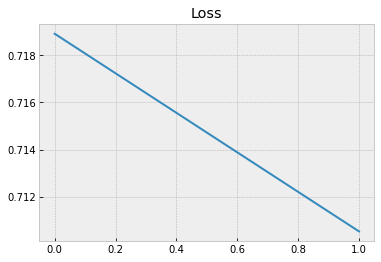

In [52]:
plt.plot(loss_history)
plt.title('Loss')

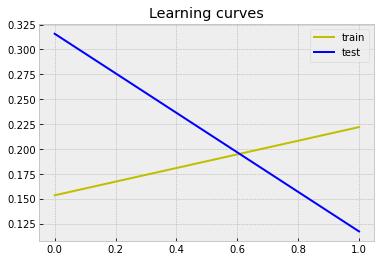

In [53]:
plt.plot(train_history, label='train', c='y')
plt.plot(val_history, label='test', c='blue')
plt.title('Learning curves')
plt.legend();

# Сабмит

In [54]:
test_dataset = SiburPredictDataset(test['full_name'].values)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

In [55]:
# тест функции
preds = np.random.random(len(test))

In [56]:
#preds = model.predict(test_loader)

In [57]:
def submit(preds, threshold=0.5, filename='submit.csv'):
    labels = (preds > threshold).astype(int)
    result = pd.DataFrame({'pair_id': test.index,
                           'is_duplicate': labels})
    print(f'Число положительных классов для threshold={threshold}: {result["is_duplicate"].sum()} / {result["is_duplicate"].mean():.2%}')
    result.to_csv(filename, index=False)
    print('Done!')

In [58]:
for thr in [0.5, 0.6, 0.7, 0.8, 0.9]:
    filename = f'submit_{thr}.csv'
    submit(preds, threshold=thr, filename=filename)

Число положительных классов для threshold=0.5: 106693 / 50.03%
Done!
Число положительных классов для threshold=0.6: 85230 / 39.97%
Done!
Число положительных классов для threshold=0.7: 64067 / 30.04%
Done!
Число положительных классов для threshold=0.8: 42753 / 20.05%
Done!
Число положительных классов для threshold=0.9: 21341 / 10.01%
Done!
